<a href="https://colab.research.google.com/github/rangwani-harsh/BottomUpTopDownAttention/blob/master/bottom_up_top_down_attention_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This work is a different model for image captioning. We thank the Tensorflow authors for such an awesome tutorial on image captioning [link](https://www.tensorflow.org/beta/tutorials/text/image_captioning). We have reused a lot of that code here. 

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image Captioning with Attention

<table class="tfo-notebook-buttons" align="left">
<td>
    <a target="_blank" href="https://github.com/rangwani-harsh/BottomUpTopDownAttention">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

Given an image like the example below, our goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Bottom-Up and Top-Down Attention for Image Captioning and Visual Question Answering](https://arxiv.org/abs/1707.07998).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses the captions and downloads the features for each image and caches them on the disk, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import csv
import sys
import base64
import nltk

     |████████████████████████████████| 332.1MB 59kB/s 
     |████████████████████████████████| 3.0MB 30.7MB/s 
     |████████████████████████████████| 61kB 28.8MB/s 
     |████████████████████████████████| 419kB 41.3MB/s 


## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [0]:
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

zips = ['train2014.zip', 'traival_36.zip', 'test2014_36.zip']
origins = ['http://images.cocodataset.org/zips/train2014.zip', 'https://imagecaption.blob.core.windows.net/imagecaption/trainval_36.zip', 'https://imagecaption.blob.core.windows.net/imagecaption/test2014_36.zip']

for name_of_zip,origin in zip(zips,origins):
  if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
    image_zip = tf.keras.utils.get_file(name_of_zip,
                                        cache_subdir=os.path.abspath('.'),
                                        origin = origin,
                                        extract = True)
    PATH = os.path.dirname(image_zip)+'/train2014/'
  else:
    PATH = os.path.abspath('.')+'/train2014/'
  

9615368192/9615364702 [==============================] - 697s 0us/step


## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.

In [0]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [0]:
len(train_captions), len(all_captions)

(30000, 414113)

## Download Feature Dict and Save Feat to npy files


## Caching the features extracted from Faster RCNN trained using Resnet on Visual Genome Dataset

You will downloads features for each image obtained from a Faster CNN trained using Resnet and cache the output to disk. Caching the output in RAM would be faster but also memory intensive. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory). The features are obtained from this repo 

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

 If you'd like to see a progress bar, you can: 

1. install [tqdm](https://github.com/tqdm/tqdm):

    ```!pip install tqdm```

2. Import tqdm:

    ```from tqdm import tqdm```

3. Change the following line:

    ```for img, path in image_dataset:```

    to:

    ```for img, path in tqdm(image_dataset):```.

In [0]:

csv.field_size_limit(sys.maxsize)
FIELDNAMES = ['image_id', 'image_w','image_h','num_boxes', 'boxes', 'features']

infile = [ 'trainval_36/trainval_resnet101_faster_rcnn_genome_36.tsv' ]

def convert_to_numpy_array(infile):
  with open(infile, "r+") as tsv_in_file:
      reader = csv.DictReader(tsv_in_file, delimiter='\t', fieldnames = FIELDNAMES)
      for item in reader:
          item['image_id'] = int(item['image_id'])
          item['image_h'] = int(item['image_h'])
          item['image_w'] = int(item['image_w'])   
          item['num_boxes'] = int(item['num_boxes'])
          for field in ['boxes', 'features']:
              item[field] = np.frombuffer(base64.b64decode(item[field]), 
                    dtype=np.float32).reshape((item['num_boxes'],-1))
          np.save(PATH + 'COCO_train2014_' + '%012d.jpg' % (item['image_id']), item['features'])
          
          


          


In [0]:
for file in infile:
  convert_to_numpy_array(file)

In [0]:
arr = np.load('train2014/COCO_train2014_000000000359.jpg.npy')
arr.shape


ls: cannot access 'checkpoints/train/': No such file or directory


## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to the be same length as the longest one.

In [0]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [0]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [0]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [0]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [0]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

## Create a tf.data dataset for training



 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [0]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64
num_boxes = 36

In [0]:
def pad_up_to(t, max_in_dims, constant_values):
    s = tf.shape(t)
    paddings = [[0, m-s[i]] for (i,m) in enumerate(max_in_dims)]
    return tf.pad(t, paddings, 'CONSTANT', constant_values=constant_values)

# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  #img_tensor = pad_up_to(img_tensor, [num_boxes, features_shape], 0)
  return img_tensor, cap

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

W0607 17:06:01.570598 140202366740352 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/script_ops.py:476: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


## Model



The model architecture is inspired by the [Bottom-Up and Top-Down Attention for Image Captioning and Visual Question Answering](https://arxiv.org/abs/1707.07998) paper.

* In this example we generate a 2048 dimensional feature for a bounding box which is obtained through Faster RCNN. Faster RCNN can be downloaded by this repo  [weights](https://github.com/peteanderson80/bottom-up-attention) 
* The first of the two GRU's are responsible for calculating the attention on the different bounding boxes.
* The second GRU then uses the attention based representation of the bounding boxes to predict the next word.
* We use GRU's in place of LSTM which were used by the author's to speed up the implementation



In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
class Encoder(tf.keras.Model):
    # This encoder does nothing just passes the representation recieved to the decoder
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        

    def call(self, x):
        return x

In [0]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units
    
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru_attention = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.gru_output = tf.keras.layers.GRU(self.units,
                                         return_sequences = True,
                                         return_state = True,
                                         recurrent_initializer='glorot_uniform')
    
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention_layers = []
    
    for i in range(self.num_attention_layers):
      self.attention_layers.append(BahdanauAttention(self.units))
   

  def call(self, x, features, hidden_output_gru):
    num_of_boxes = features.shape[1]
    
    # shape after passing through embedding == (batch_size, feature_dim)
    pooled_features = tf.keras.backend.sum(features, axis = 1)/num_of_boxes

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size+featured_dim)
    x = tf.concat([tf.expand_dims(pooled_features, 1), x, tf.expand_dims(hidden_output_gru, 1)], axis=-1)
    
    # passing the concatenated vector to the GRU
    output_attention_gru, state_attention_gru = self.gru_attention(x)
    
    
    # shape == (batch_size, feature_dim, 1)
    final_context_vector, final_attention_weights = self.attention_layers[0](features, state_attention_gru)
    final_attention_weights = tf.expand_dims(final_attention_weights, 1)
    
    for i in range(self.num_attention_layers-1):
      image_context_vector, attention_weights = self.attention_layers[i+1](features, state_attention_gru)
      final_context_vector = tf.concat([final_context_vector,image_context_vector], -1)
      final_attention_weights = tf.concat([final_attention_weights, tf.expand_dims(attention_weights, 1)], -1)
    
    # Shape of final_context_vector = (batch_size, num_attention_layers * feature_size)
    # Shape of final_attention_weights = (batch_size, num_of_boxes, num_attention_layers)
    
    
    # Create input for the second gru
    x = tf.concat([tf.expand_dims(final_context_vector, 1), tf.expand_dims(state_attention_gru,1)], axis = -1)
    
    output_gru, state_output_gru = self.gru_output(x)
    
    x = self.fc1(output_gru)
    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc(x)

    return x, state_output_gru, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [0]:
encoder = Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [0]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [0]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [0]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
          
          loss += loss_function(target[:, i], predictions)
          loss += frobenius_regularization_penalty(attention_weights)/BATCH_SIZE
          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [0]:
EPOCHS = 15

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 5 Batch 0 Loss 7.9301
Epoch 5 Batch 100 Loss 7.0416
Epoch 5 Batch 200 Loss 7.0717
Epoch 5 Batch 300 Loss 6.8035
Epoch 5 Loss 6.982391
Time taken for 1 epoch 502.5502851009369 sec

Epoch 6 Batch 0 Loss 6.7933
Epoch 6 Batch 100 Loss 6.8051
Epoch 6 Batch 200 Loss 6.8465
Epoch 6 Batch 300 Loss 6.6712
Epoch 6 Loss 6.773884
Time taken for 1 epoch 352.5638961791992 sec

Epoch 7 Batch 0 Loss 6.7074
Epoch 7 Batch 100 Loss 6.7387
Epoch 7 Batch 200 Loss 6.7828
Epoch 7 Batch 300 Loss 6.6236
Epoch 7 Loss 6.717264
Time taken for 1 epoch 348.93709921836853 sec

Epoch 8 Batch 0 Loss 6.6707
Epoch 8 Batch 100 Loss 6.7091
Epoch 8 Batch 200 Loss 6.7469
Epoch 8 Batch 300 Loss 6.5993
Epoch 8 Loss 6.685375
Time taken for 1 epoch 348.0916864871979 sec

Epoch 9 Batch 0 Loss 6.6457
Epoch 9 Batch 100 Loss 6.6854
Epoch 9 Batch 200 Loss 6.7247
Epoch 9 Batch 300 Loss 6.5795
Epoch 9 Loss 6.662022
Time taken for 1 epoch 347.8421311378479 sec

Epoch 10 Batch 0 Loss 6.6198
Epoch 10 Batch 100 Loss 6.6688
Epoch 10 

KeyboardInterrupt: ignored

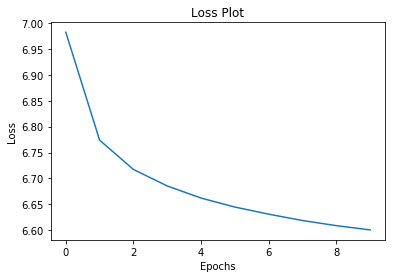

In [0]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [0]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    
    img_tensor_val = np.load(image + '.npy')
    img_tensor_val = pad_up_to(img_tensor_val, [num_boxes, features_shape], 0)
    img_tensor_val = tf.reshape(img_tensor_val, (-1, img_tensor_val.shape[0], img_tensor_val.shape[1]))

    #img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        print(dec_input)
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        
        #attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    #attention_plot = attention_plot[:len(result), :]
    return result

In [0]:
def evaluate_with_beam_search(image, beam_width):
  
    hidden = decoder.reset_state(batch_size=1)
    img_tensor_val = np.load(image + '.npy')
    img_tensor_val = pad_up_to(img_tensor_val, [num_boxes, features_shape], 0)
    img_tensor_val = tf.reshape(img_tensor_val, (-1, img_tensor_val.shape[0], img_tensor_val.shape[1]))
    features = encoder(img_tensor_val)
    beam_list = [[[tokenizer.word_index['<start>']],0.0, hidden]]
    
    
    for i in range(max_length):
      new_beam_list= [] # This will have the maximum length of beam_width*beam_width
      
      for beam in beam_list:
        sequence, log_prob, hidden = beam
        
        if tokenizer.index_word[sequence[-1]] == '<end>': # Don't apply beam search after the end token has reached
          new_beam_list.append(beam)
        else:
          dec_input = tf.expand_dims([sequence[-1]], 0)
          predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
          predictions = tf.math.log(tf.nn.softmax(predictions))
          top_predictions = np.argsort(predictions[0])[-beam_width:]
          for pid in top_predictions:
            log_prob_new = log_prob + predictions[0][pid]
            new_list = sequence + [pid]
            new_beam_list.append([new_list, log_prob_new, hidden])
        
      sorted_beams = sorted(new_beam_list, reverse=False, key=lambda l: l[1])
       
      beam_list = sorted_beams[-beam_width:]
        
    
    final_ids = beam_list[-1][0]
    
    result = [tokenizer.index_word[w_id] for w_id in final_ids]
    
    
    return result[0:]

        
      
    
  

In [0]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

tf.Tensor([[3]], shape=(1, 1), dtype=int32)
tf.Tensor([[2]], shape=(1, 1), dtype=int32)
tf.Tensor([[12]], shape=(1, 1), dtype=int32)
tf.Tensor([[11]], shape=(1, 1), dtype=int32)
tf.Tensor([[11]], shape=(1, 1), dtype=int32)
tf.Tensor([[11]], shape=(1, 1), dtype=int32)
tf.Tensor([[11]], shape=(1, 1), dtype=int32)
tf.Tensor([[11]], shape=(1, 1), dtype=int32)
tf.Tensor([[11]], shape=(1, 1), dtype=int32)
tf.Tensor([[11]], shape=(1, 1), dtype=int32)
tf.Tensor([[11]], shape=(1, 1), dtype=int32)
tf.Tensor([[11]], shape=(1, 1), dtype=int32)
tf.Tensor([[11]], shape=(1, 1), dtype=int32)
tf.Tensor([[11]], shape=(1, 1), dtype=int32)
tf.Tensor([[11]], shape=(1, 1), dtype=int32)
tf.Tensor([[11]], shape=(1, 1), dtype=int32)
tf.Tensor([[11]], shape=(1, 1), dtype=int32)
tf.Tensor([[11]], shape=(1, 1), dtype=int32)
tf.Tensor([[11]], shape=(1, 1), dtype=int32)
tf.Tensor([[11]], shape=(1, 1), dtype=int32)
tf.Tensor([[11]], shape=(1, 1), dtype=int32)
tf.Tensor([[11]], shape=(1, 1), dtype=int32)
tf.Tensor([[

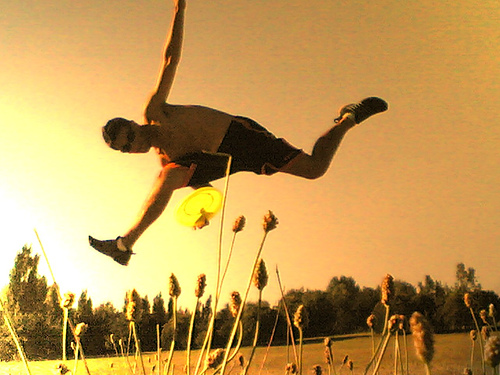

In [0]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result = evaluate_with_beam_search(image, 2)
result_eval = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption Beam Search:', ' '.join(result))
print ('Prediction Caption Greedy:', ' '.join(result_eval))
#plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])

## Calculate Bleu score for the images
For evaluating the model we use all the reference captions and calculate the bleu score using all the reference captions.


In [0]:

val_image_to_captions = {}

for j, image_name in enumerate(img_name_val):
  if image_name not in val_image_to_captions:
    val_image_to_captions[image_name] = [[tokenizer.index_word[i] for i in cap_val[j] if i not in [0]]]
  else:
    val_image_to_captions[image_name].append([tokenizer.index_word[i] for i in cap_val[j] if i not in [0]])
    
bleu_score = 0
for i, image in enumerate(val_image_to_captions):
  result = evaluate_with_beam_search(image,3)
  caption_bleu = nltk.translate.bleu_score.sentence_bleu(val_image_to_captions[image], result)
  if i%100 == 0:
    print("Processed {} number of images".format(i+1))
  bleu_score += caption_bleu
  
print("The average bleu score of the captions is {}".format(bleu_score/len(val_image_to_captions)))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Processed 1 number of images


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Processed 101 number of images
Processed 201 number of images
Processed 301 number of images
Processed 401 number of images
Processed 501 number of images
Processed 601 number of images
Processed 701 number of images
Processed 801 number of images
Processed 901 number of images
Processed 1001 number of images
Processed 1101 number of images
Processed 1201 number of images
Processed 1301 number of images
Processed 1401 number of images
Processed 1501 number of images
Processed 1601 number of images
Processed 1701 number of images
Processed 1801 number of images
Processed 1901 number of images
Processed 2001 number of images
Processed 2101 number of images
Processed 2201 number of images
Processed 2301 number of images
Processed 2401 number of images
Processed 2501 number of images
Processed 2601 number of images
Processed 2701 number of images
Processed 2801 number of images
Processed 2901 number of images
Processed 3001 number of images
Processed 3101 number of images
Processed 3201 nu

# Possible New steps

It seems that with these images our model is not able to identify groups and generated captions are also smaller which can be mitigated by introduction of an adversarial loss that discriminates between real and original captions.

Please note that this not the official implementation and is just for educational purpose. Please visit the original repo for official code https://github.com/peteanderson80/bottom-up-attention